In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from scipy.stats import poisson
from scipy.optimize import minimize
from dataclasses import dataclass

In [23]:
@dataclass
class Team:
    '''
    stores some basic information about a team
    '''
    name: str
    attack: float
    defence: float

@dataclass
class Settings:
    '''
    store the settings (hyperparameters) used
    sd_movement = sd of change in team abilities between seasons
        (higher -> team ratings are allowed to change more)
    '''
    sd_movement: float

In [29]:
def make_date(datestr: str) -> date:
    '''
    reformat date string DD/MM/YYYY into datetime date
    '''
    info = datestr.split("/")
    day = int(info[0])
    month = int(info[1])
    year = int(info[2])
    return date(year, month, day)

def calculate_season(date: date) -> int:
    '''
    figure out what season we are in (2023/24 season is called 2024)
    '''
    if date.month >= 7:
        return date.year
    return date.year - 1



def gather_matches(match_data: pd.DataFrame, team_idx: dict) -> np.ndarray:
    '''
    takes a dataframe of matches and converts it into a np array with just basic information
    output: array of tuples of matches (home index, away index, home goals, away goals)
    '''
    match_data = match_data.copy()
    match_data["h_idx"] = match_data["HomeTeam"].apply(lambda x: team_idx[x])
    match_data["a_idx"] = match_data["AwayTeam"].apply(lambda x: team_idx[x])

    match_data = match_data[["h_idx", "a_idx", "FTHG", "FTAG"]]
    matches = [tuple(i) for i in match_data.itertuples(index=False, name=None)]

    return np.array(matches)

def neg_log_season(theta: list[float], matches_array: np.ndarray, n_teams: int) -> float:
    attacks = theta[:n_teams]
    defences = theta[n_teams:2*n_teams]
    home_adv = theta[-1]

    attacks = attacks - np.mean(attacks)  # identifiability

    h_idx = matches_array[:, 0].astype(int)
    a_idx = matches_array[:, 1].astype(int)
    h_goals = matches_array[:, 2].astype(int)
    a_goals = matches_array[:, 3].astype(int)

    lam_h = np.exp(home_adv + attacks[h_idx] - defences[a_idx])
    lam_h = np.clip(lam_h, 1e-10, 1e2)  # prevent underflow / overflow

    lam_a = np.exp(-home_adv + attacks[a_idx] - defences[h_idx])
    lam_a = np.clip(lam_a, 1e-10, 1e2)

    log_like = poisson.logpmf(h_goals, lam_h) + poisson.logpmf(a_goals, lam_a)
    return -np.sum(log_like)


def p_total_over(goals: float, home_team: Team, away_team: Team, home_adv: float) -> float:
    lam_h = np.exp(home_adv + home_team.attack - away_team.defence)
    lam_a = np.exp(-home_adv + away_team.attack - home_team.defence)
    lam = lam_h + lam_a
    prob = 1 - poisson.cdf(np.floor(goals), lam)
    return prob

def p_over(goals: float, home_team: Team, away_team: Team, home_adv: float, home_or_away: str) -> float:
    if home_or_away == "home":
        lam = np.exp(home_adv + home_team.attack - away_team.defence)
        return 1 - poisson.cdf(np.floor(goals), lam)
    lam = np.exp(-home_adv + away_team.attack - home_team.defence)
    return 1 - poisson.cdf(lam, np.floor(goals))

def log_likelihood(big_theta: np.ndarray, seasons: dict, n_teams: int, team_idx: dict, settings: Settings) -> float:
    # take theta and break it into components (season by seasons ratings + home adv)
    unique_seasons = list(seasons.keys())
    n_seasons = len(unique_seasons)
    thetas=dict()
    home_adv = big_theta[-1]
    for season in range(n_seasons):
        curr_theta = big_theta[2*n_teams*season:2*n_teams*(season+1)]
        curr_theta = np.append(curr_theta, home_adv)
        thetas[unique_seasons[season]] = curr_theta

    # for each season, calculate (negative) log-likelihood and add to total
    nll = 0
    for season in seasons.keys():
        matches = seasons[season]
        theta = thetas[season]
        nll += neg_log_season(theta=theta, matches_array=matches, n_teams=n_teams)


    # now calculate nll of change in rating between seasons
    # stack all season ratings into array (n_seasons, n_teams)
    attack_ratings = np.stack([big_theta[2*n_teams*season:2*n_teams*season + n_teams] for season in range(n_seasons)], axis=0)
    defence_ratings = np.stack([big_theta[2*n_teams*season + n_teams : 2*n_teams*(season+1)] for season in range(n_seasons)], axis=0)

    # differences across seasons
    attack_diffs = attack_ratings[1:] - attack_ratings[:-1]  # shape (n_seasons-1, n_teams)
    defence_diffs = defence_ratings[1:] - defence_ratings[:-1]

    # log-likelihood contribution from random walk
    sd = settings.sd_movement
    n = n_seasons - 1

    # vectorised
    rw_ll = -0.5 * n * np.log(2*np.pi) - n * np.log(sd) - np.sum(attack_diffs**2) / (2*sd**2)
    rw_ll += -0.5 * n * np.log(2*np.pi) - n * np.log(sd) - np.sum(defence_diffs**2) / (2*sd**2)

    # subtract because your function returns nll
    nll -= rw_ll
    return nll

def theta_to_df(big_theta: np.ndarray, season_matches: dict, teams: list[str], n_teams: int) -> pd.DataFrame:
    """
    Convert flat theta vector into a DataFrame of team ratings per season using preprocessed data.

    Parameters
    ----------
    big_theta : np.ndarray
        Flat array containing all attack/defence ratings for all seasons + home_adv at the end
    season_matches : dict
        Dictionary mapping season -> np.ndarray of matches (h_idx, a_idx, h_goals, a_goals)
    teams : list of str
        List of team names in order corresponding to indices in theta
    n_teams : int
        Number of teams

    Returns
    -------
    pd.DataFrame
        Columns: ["Season", "Team", "Attack", "Defence"]
        Plus a final row for home advantage
    """
    home_adv = big_theta[-1]
    rows = []

    # Sort seasons so theta slices match
    sorted_seasons = sorted(season_matches.keys())
    n_seasons = len(sorted_seasons)

    for season_idx, season in enumerate(sorted_seasons):
        # slice out season-specific parameters
        season_theta = big_theta[2*n_teams*season_idx : 2*n_teams*(season_idx+1)]
        attacks = season_theta[:n_teams]
        defences = season_theta[n_teams:2*n_teams]

        # optional: mean-zero attacks for identifiability
        attacks = attacks - np.mean(attacks)

        for i, team in enumerate(teams):
            rows.append({
                "Season": season,
                "Team": team,
                "Attack": attacks[i],
                "Defence": defences[i]
            })

    # Add home advantage row
    rows.append({
        "Season": "All",
        "Team": "HomeAdv",
        "Attack": home_adv,
        "Defence": np.nan
    })

    df = pd.DataFrame(rows)
    return df


def omniscient_backtest(df_ratings: pd.DataFrame, match_data: pd.DataFrame):
    '''
    a backtest that uses attacking/defensive ratings and match data to bet on
    over/under 2.5 goals, using Bet365 odds as our book
    omniscient in that it uses ratings that were probably calculated using future data
    this makes it slightly unrealistic, and real returns may not be as good, if positive at all!

    this function is not very optimised, so takes a few seconds to run. could be optimised if needed
    '''
    money = 0
    n_bets = 0
    dates = []
    pnl = []

    # get the home advantage from the df
    home_adv = df_ratings.loc[df_ratings["Team"]=="HomeAdv", "Attack"].iloc[0]
    for _, match in match_data.iterrows():
        # get important information about the match
        season = match["Season"]
        date = match["Date"]
        curr_ratings = df_ratings[df_ratings["Season"]==season]

        # get important information about the teams
        h_name = match["HomeTeam"]
        h_att = curr_ratings.loc[curr_ratings["Team"]==h_name, "Attack"].iloc[0]
        h_def = curr_ratings.loc[curr_ratings["Team"]==h_name, "Defence"].iloc[0]

        a_name = match["AwayTeam"]
        a_att = curr_ratings.loc[curr_ratings["Team"]==a_name, "Attack"].iloc[0]
        a_def = curr_ratings.loc[curr_ratings["Team"]==a_name, "Defence"].iloc[0]

        # package the teams into Team dataclass
        home_team = Team(h_name, h_att, h_def)
        away_team = Team(a_name, a_att, a_def)

        # check if the over bet is underpriced, if it is, bet
        fair = 1/p_total_over(2.5, home_team=home_team, away_team=away_team, home_adv=home_adv)
        odds = match["B365>2.5"]
        if fair < odds:

            total = match["FTHG"] + match["FTAG"]
            if total > 2.5:
                money += odds - 1
            else:
                money -= 1
            

        # check if the under bet is underpriced, if it is, bet
        fair = 1/(1-1/fair)
        odds = match["B365<2.5"]
        if fair < odds:
            total = match["FTHG"] + match["FTAG"]
            if total < 2.5:
                money += odds - 1
            else:
                money -= 1
        pnl.append(money)
        dates.append(date)

    df = pd.DataFrame({
        "pnl": pnl,
        "date": dates
    })
    return df

In [25]:
'''
preprocessing and formatting work
'''

match_data = pd.read_csv("EPL.csv")
match_data["Date"] = match_data["Date"].apply(make_date)            # reformat date

match_data["Season"] = match_data["Date"].apply(calculate_season)   # figure out what season we're in

match_data.sort_values(by="Date",inplace=True)                      # sort data by date
match_data = match_data.reset_index(drop=True)

teams = list(match_data["HomeTeam"].unique())
team_idx = {j:i for i,j in enumerate(teams)}        # convert teams to an index for easy 
                                                        #lookup and vectorisation of processes further down the line

n_teams = len(team_idx)


seasons = dict(tuple(match_data.groupby("Season"))) # split the data into seasons
n_seasons = len(seasons)

season_matches = {                                  # group the data into seasons and make them lists of tuples for vectorisation
    season: gather_matches(df, team_idx)
    for season, df in seasons.items()
}

In [ ]:
'''
fitting the data using our minimize library
this is essentially MLE
should take 5-10 seconds to run, maybe longer
'''

settings = Settings(0.1)


# initially assume all teams have zero rating in both aspects

theta0 = np.zeros(2*n_seasons*n_teams+1)
theta0[-1] = 0.1    # and assume the home advantage is 0.1

res = minimize(
    fun=log_likelihood,
    x0=theta0,
    args=(season_matches,n_teams, team_idx, settings),
    method="L-BFGS-B"
)

In [27]:
ratings=res.x
# convert the results into a readable dataframe
df_ratings = theta_to_df(ratings, season_matches, teams, n_teams)
df_ratings

,Season,Team,Attack,Defence
0,2021,Brentford,0.077350,-0.248216
1,2021,Man United,0.134748,-0.227602
2,2021,Burnley,-0.291833,-0.345800
3,2021,Chelsea,0.271590,0.010092
4,2021,Everton,-0.205321,-0.324668
...,...,...,...,...
131,2025,Sheffield United,-0.324542,-0.847874
132,2025,Luton,0.052828,-0.656936
133,2025,Ipswich,-0.291096,-0.622369
134,2025,Sunderland,-0.214557,0.137113


In [30]:
results = omniscient_backtest(df_ratings=df_ratings, match_data=match_data)

In [ ]:
x = results["date"]
y=results["pnl"]

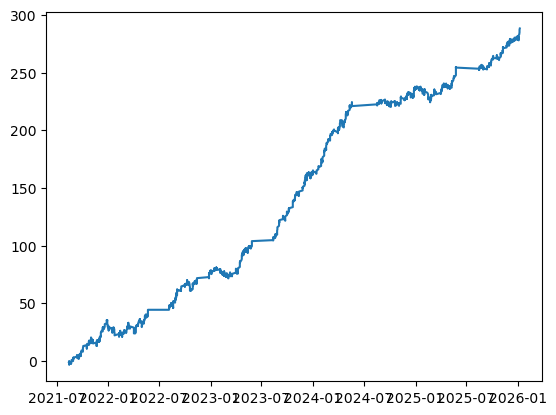

In [31]:
'''
plot the results
as we can see, the 23-24 season was highly successful, but every other season was also successful
this is impressive and surprising to me
'''

plt.plot(x,y)